In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

import gurobipy as gp
from gurobipy import GRB, Model
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 30, 60, 90, 180, 365
df_30 = pd.read_csv("2021_optimized_portfolio_monthlyrebalance_30datapoints.csv")
df_60 = pd.read_csv("2021_optimized_portfolio_monthlyrebalance_60datapoints.csv")
df_90 = pd.read_csv("2021_optimized_portfolio_monthlyrebalance_90datapoints.csv")
df_180 = pd.read_csv("2021_optimized_portfolio_monthlyrebalance_180datapoints.csv")
df_365 = pd.read_csv("2021_optimized_portfolio_monthlyrebalance_365datapoints.csv")

In [3]:
# info dataset
df_30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Month                  12 non-null     object 
 1   Lookback_Days          12 non-null     int64  
 2   total_expected_return  12 non-null     float64
 3   portfolio_risk         12 non-null     float64
 4   stock                  12 non-null     object 
 5   weight                 12 non-null     object 
 6   allocations            12 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 800.0+ bytes


# 2021 Monthly Returns Percentage

In [4]:
df = pd.read_csv("raw.csv", parse_dates=['date'])
df_information = pd.read_csv("info.csv")

In [5]:
start_date = pd.Timestamp('2020-12-31')
end_date = pd.Timestamp('2021-12-31')

filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
filtered_df = filtered_df.sort_values(by='date').reset_index(drop=True)

filtered_df

,date,ticker,adj_close
0,2020-12-31,SCPI.JK,29000.00
1,2021-01-04,FORU.JK,128.00
2,2021-01-04,MCAS.JK,4200.00
3,2021-01-04,ASMI.JK,1000.00
4,2021-01-04,MASA.JK,1000.00
...,...,...,...
181632,2021-12-30,MASB.JK,3550.00
181633,2021-12-30,MIKA.JK,2200.48
181634,2021-12-30,MLBI.JK,7109.54
181635,2021-12-30,HITS.JK,384.00


In [6]:
# nama ticker
tickers = filtered_df['ticker'].unique()

In [7]:
# monthly returns
monthly_returns = pd.DataFrame(columns=['ticker', 'month', 'monthly_return_percentage'])

for ticker in tickers:
    ticker_data = filtered_df[filtered_df['ticker'] == ticker]
    for month in range(1, 13):
        month_data = ticker_data[(ticker_data['date'].dt.year == 2021) & (ticker_data['date'].dt.month == month)]
        if not month_data.empty:
            adj_close_start = month_data.iloc[0]['adj_close']  # awal bulan
            adj_close_end = month_data.iloc[-1]['adj_close']   # akhir bulan

            # print awal bulan dan akhir bulan
            # print(f"{ticker} - 2021-{month:02}: Awal bulan = {adj_close_start}, Akhir bulan = {adj_close_end}")

            # persentase bulanan return
            monthly_return_percentage = ((adj_close_end - adj_close_start) / adj_close_start) * 100
            
            temp_df = pd.DataFrame({
                'ticker': [ticker],
                'month': [f'2021-{month:02}'],
                'monthly_return_percentage': [monthly_return_percentage]
            })

            monthly_returns = pd.concat([monthly_returns, temp_df], ignore_index=True)

In [8]:
monthly_returns

,ticker,month,monthly_return_percentage
0,SCPI.JK,2021-01,0.000000
1,SCPI.JK,2021-02,0.000000
2,SCPI.JK,2021-03,0.000000
3,SCPI.JK,2021-04,0.000000
4,SCPI.JK,2021-05,0.000000
...,...,...,...
8832,AVIA.JK,2021-12,6.936416
8833,IPPE.JK,2021-12,39.259259
8834,NASI.JK,2021-12,7.692308
8835,BSML.JK,2021-12,23.566879


In [9]:
monthly_returns.to_csv("tickers_monthly_returns_percentage_2021.csv", index=False)

# Portfolio Values

In [10]:
monthly_returns = pd.read_csv("tickers_monthly_returns_percentage_2021.csv")
monthly_returns

,ticker,month,monthly_return_percentage
0,SCPI.JK,2021-01,0.000000
1,SCPI.JK,2021-02,0.000000
2,SCPI.JK,2021-03,0.000000
3,SCPI.JK,2021-04,0.000000
4,SCPI.JK,2021-05,0.000000
...,...,...,...
8832,AVIA.JK,2021-12,6.936416
8833,IPPE.JK,2021-12,39.259259
8834,NASI.JK,2021-12,7.692308
8835,BSML.JK,2021-12,23.566879


In [11]:
df_30

,Month,Lookback_Days,total_expected_return,portfolio_risk,stock,weight,allocations
0,2021-01,30,534.526066,11.076236,"['AGRO.JK', 'PTDU.JK']","[0.1, 0.9]","AGRO.JK: 0.10%, PTDU.JK: 0.90%"
1,2021-02,30,1151.675824,11.160090,"['BBHI.JK', 'DCII.JK']","[0.1, 0.9]","BBHI.JK: 0.10%, DCII.JK: 0.90%"
2,2021-03,30,1367.625899,12.843715,['BANK.JK'],[1.0],BANK.JK: 1.00%
3,2021-04,30,543.660714,12.667667,"['BANK.JK', 'ZBRA.JK']","[0.1, 0.9]","BANK.JK: 0.10%, ZBRA.JK: 0.90%"
4,2021-05,30,575.299505,10.462352,"['BINA.JK', 'KONI.JK', 'PNBS.JK']","[0.0, 0.9, 0.1]","BINA.JK: 0.00%, KONI.JK: 0.90%, PNBS.JK: 0.10%"
5,2021-06,30,414.359392,19.999967,"['BABP.JK', 'BYAN.JK', 'KONI.JK', 'SAMF.JK']","[0.1, 0.23, 0.07, 0.6]","BABP.JK: 0.10%, BYAN.JK: 0.23%, KONI.JK: 0.07%..."
6,2021-07,30,431.136494,19.999958,"['BABP.JK', 'BYAN.JK', 'DCII.JK']","[0.1, 0.18, 0.72]","BABP.JK: 0.10%, BYAN.JK: 0.18%, DCII.JK: 0.72%"
7,2021-08,30,168.558881,7.775797,"['BOLA.JK', 'BSIM.JK']","[0.9, 0.1]","BOLA.JK: 0.90%, BSIM.JK: 0.10%"
8,2021-09,30,946.664281,10.120447,"['BBYB.JK', 'PEGE.JK']","[0.1, 0.9]","BBYB.JK: 0.10%, PEGE.JK: 0.90%"
9,2021-10,30,256.519824,9.458778,"['AYLS.JK', 'BBHI.JK']","[0.9, 0.1]","AYLS.JK: 0.90%, BBHI.JK: 0.10%"


In [12]:
# parsing string list
def parse_column(column):
    return column.apply(lambda x: ast.literal_eval(x))

# simulasi portfolio
def simulate_portfolio(df, monthly_returns, initial_fund=1e8): # 100_000_000
    portfolio_value = initial_fund
    portfolio_history = []

    for i, row in df.iterrows():
        month = row['Month']
        stock_list = row['stock']
        weights = row['weight']

        # alokasi setiap bulan
        stock_allocations = {stock: portfolio_value * float(weight) for stock, weight in zip(stock_list, weights)}
        
        # update nilai alokasi
        for stock, allocation in stock_allocations.items():
            stock_return = monthly_returns[(monthly_returns['ticker'] == stock) & (monthly_returns['month'] == month)]
            if not stock_return.empty:
                # persentase return bulanan
                return_percentage = float(stock_return['monthly_return_percentage'].values[0]) / 100
                # update nilai alokasi saham berdasarkan return bulanan
                stock_allocations[stock] = allocation * (1 + return_percentage)

        # total nilai total portofolio setelah return
        portfolio_value = sum(stock_allocations.values())
        portfolio_history.append({'Period': month, 'portfolio_value': portfolio_value})

    return pd.DataFrame(portfolio_history)

In [13]:
# lookback 30 days
df_30['stock'] = parse_column(df_30['stock'])
df_30['weight'] = parse_column(df_30['weight'])

portfolio_history_30 = simulate_portfolio(df_30, monthly_returns)
portfolio_history_30

,Period,portfolio_value
0,2021-01,9.789216e+07
1,2021-02,1.471269e+08
2,2021-03,2.052033e+08
3,2021-04,3.804585e+08
4,2021-05,3.001668e+08
5,2021-06,2.139906e+08
6,2021-07,2.230222e+08
7,2021-08,2.400813e+08
8,2021-09,2.018394e+08
9,2021-10,1.534810e+08


In [14]:
# lookback 60 days
df_60['stock'] = parse_column(df_60['stock'])
df_60['weight'] = parse_column(df_60['weight'])

portfolio_history_60 = simulate_portfolio(df_60, monthly_returns)
portfolio_history_60

,Period,portfolio_value
0,2021-01,9.789216e+07
1,2021-02,1.096253e+08
2,2021-03,1.002327e+08
3,2021-04,1.039452e+08
4,2021-05,1.079512e+08
5,2021-06,1.044975e+08
6,2021-07,9.473956e+07
7,2021-08,4.918387e+07
8,2021-09,4.134949e+07
9,2021-10,4.088283e+07


In [15]:
# lookback 90 days
df_90['stock'] = parse_column(df_90['stock'])
df_90['weight'] = parse_column(df_90['weight'])

portfolio_history_90 = simulate_portfolio(df_90, monthly_returns)
portfolio_history_90

,Period,portfolio_value
0,2021-01,5.602080e+07
1,2021-02,8.419638e+07
2,2021-03,7.698246e+07
3,2021-04,7.983380e+07
4,2021-05,7.337327e+07
5,2021-06,7.477085e+07
6,2021-07,7.250626e+07
7,2021-08,8.249962e+07
8,2021-09,6.714028e+07
9,2021-10,6.544449e+07


In [16]:
# lookback 180 days
df_180['stock'] = parse_column(df_180['stock'])
df_180['weight'] = parse_column(df_180['weight'])

portfolio_history_180 = simulate_portfolio(df_180, monthly_returns)
portfolio_history_180

,Period,portfolio_value
0,2021-01,1.033898e+08
1,2021-02,1.435144e+08
2,2021-03,1.037007e+08
3,2021-04,1.075417e+08
4,2021-05,9.883891e+07
5,2021-06,3.281537e+08
6,2021-07,3.302307e+08
7,2021-08,2.876499e+08
8,2021-09,2.671028e+08
9,2021-10,2.698369e+08


In [17]:
# lookback 365 days
df_365['stock'] = parse_column(df_365['stock'])
df_365['weight'] = parse_column(df_365['weight'])

portfolio_history_365 = simulate_portfolio(df_365, monthly_returns)
portfolio_history_365

,Period,portfolio_value
0,2021-01,1.003390e+08
1,2021-02,1.392796e+08
2,2021-03,1.273461e+08
3,2021-04,1.320629e+08
4,2021-05,1.213757e+08
5,2021-06,4.029779e+08
6,2021-07,4.055284e+08
7,2021-08,3.475512e+08
8,2021-09,3.227254e+08
9,2021-10,3.500413e+08


# Summarized Portfolio

### Lookback 30 Days

In [18]:
final_30 = pd.DataFrame({
    'Period': df_30['Month'].values,
    'Lookback_Days': 30, 
    'portfolio_risk': df_30['portfolio_risk'].values, 
    'stock': df_30['stock'].values, 
    'weight': df_30['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

In [19]:
def calculate_portfolio(df, monthly_returns):
    initial_cap = 1e8   # dana awal
    # kolom baru
    df['Init_Cap'] = 0.0
    df['Weighted_Invest'] = pd.Series(dtype='object')
    df['Cap_Gain/Loss'] = pd.Series(dtype='object')
    df['Return/Loss_Percentage'] = pd.Series(dtype='object')
    df['Final_Cap'] = 0.0

    for i in range(len(df)):
        # set nilai Init_Cap
        if i == 0:
            df.at[i, 'Init_Cap'] = initial_cap
        else:
            df.at[i, 'Init_Cap'] = df.at[i-1, 'Final_Cap']

        # Weighted_Invest (alokasi investasi per saham berdasarkan bobot), pembulatan 2 desimal
        df.at[i, 'Weighted_Invest'] = [round(w * df.at[i, 'Init_Cap'], 2) for w in df.at[i, 'weight']]

        # Get stock symbols and the corresponding month
        stocks = df.at[i, 'stock']
        month = df.at[i, 'Period']  # 'Period' YYYY-MM format

        # return percentages untuk stocks pada setiap bulan
        stock_returns = []
        for stock in stocks:
            monthly_return = monthly_returns.loc[
                (monthly_returns['ticker'] == stock) & (monthly_returns['month'] == month),
                'monthly_return_percentage'
            ]
            stock_returns.append(monthly_return.values[0] if not monthly_return.empty else 0)  # default 0 jika tidak ada data

        # Cap_Gain/Lost, pembulatan 2 desimal
        df.at[i, 'Cap_Gain/Loss'] = [round(w_invest * (ret / 100), 2) for w_invest, ret in zip(df.at[i, 'Weighted_Invest'], stock_returns)]

        # Final_Cap = Init_Cap + jumlah Cap_Gain/Loss
        df.at[i, 'Final_Cap'] = df.at[i, 'Init_Cap'] + sum(df.at[i, 'Cap_Gain/Loss'])
        
        # Return/Loss Percentage, pembulatan 2 desimal
        return_loss_percentage = [round((gain_loss / invest) * 100, 2) if invest != 0 else 0 for gain_loss, invest in zip(df.at[i, 'Cap_Gain/Loss'], df.at[i, 'Weighted_Invest'])]
        df.at[i, 'Return/Loss_Percentage'] = return_loss_percentage

    return df

In [20]:
final_30 = calculate_portfolio(final_30, monthly_returns)
final_30

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2021-01,30,11.076236,"[AGRO.JK, PTDU.JK]","[0.1, 0.9]",1.000000e+08,"[10000000.0, 90000000.0]","[-21.08, 0.0]","[-2107843.14, 0.0]",9.789216e+07
1,2021-02,30,11.160090,"[BBHI.JK, DCII.JK]","[0.1, 0.9]",9.789216e+07,"[9789215.69, 88102941.17]","[119.86, 42.57]","[11733173.42, 37501543.47]",1.471269e+08
2,2021-03,30,12.843715,[BANK.JK],[1.0],1.471269e+08,[147126873.75],[39.47],[58076397.53],2.052033e+08
3,2021-04,30,12.667667,"[BANK.JK, ZBRA.JK]","[0.1, 0.9]",2.052033e+08,"[20520327.13, 184682944.15]","[29.06, 91.67]","[5962510.15, 169292698.8]",3.804585e+08
4,2021-05,30,10.462352,"[BINA.JK, KONI.JK, PNBS.JK]","[0.0, 0.9, 0.1]",3.804585e+08,"[0.0, 342412632.21, 38045848.02]","[0, -20.76, -24.2]","[-0.0, -71083128.71, -9208549.2]",3.001668e+08
5,2021-06,30,19.999967,"[BABP.JK, BYAN.JK, KONI.JK, SAMF.JK]","[0.1, 0.23, 0.07, 0.6]",3.001668e+08,"[30016680.23, 69038364.53, 21011676.16, 180100...","[43.75, -3.89, -23.63, -50.89]","[13132297.6, -2683470.0, -4965087.86, -9165995...",2.139906e+08
6,2021-07,30,19.999958,"[BABP.JK, BYAN.JK, DCII.JK]","[0.1, 0.18, 0.72]",2.139906e+08,"[21399058.26, 38518304.87, 154073219.49]","[31.62, 5.88, 0.0]","[6765878.71, 2265782.64, 0.0]",2.230222e+08
7,2021-08,30,7.775797,"[BOLA.JK, BSIM.JK]","[0.9, 0.1]",2.230222e+08,"[200720019.58, 22302224.4]","[8.12, 3.37]","[16308501.59, 750555.63]",2.400813e+08
8,2021-09,30,10.120447,"[BBYB.JK, PEGE.JK]","[0.1, 0.9]",2.400813e+08,"[24008130.12, 216073171.08]","[-12.66, -16.29]","[-3039003.81, -35202932.37]",2.018394e+08
9,2021-10,30,9.458778,"[AYLS.JK, BBHI.JK]","[0.9, 0.1]",2.018394e+08,"[181655428.52, 20183936.5]","[-33.19, 59.15]","[-60297390.14, 11939039.36]",1.534810e+08


### Lookback 60 Days

In [21]:
final_60 = pd.DataFrame({
    'Period': df_60['Month'].values,
    'Lookback_Days': 60, 
    'portfolio_risk': df_60['portfolio_risk'].values, 
    'stock': df_60['stock'].values, 
    'weight': df_60['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_60 = calculate_portfolio(final_60, monthly_returns)
final_60

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2021-01,60,8.344648,"[AGRO.JK, PTDU.JK]","[0.1, 0.9]",1.000000e+08,"[10000000.0, 90000000.0]","[-21.08, 0.0]","[-2107843.14, 0.0]",9.789216e+07
1,2021-02,60,9.410299,"[BBHI.JK, TECH.JK]","[0.1, 0.9]",9.789216e+07,"[9789215.69, 88102941.17]","[119.86, 0.0]","[11733173.42, 0.0]",1.096253e+08
2,2021-03,60,9.221370,"[BANK.JK, DCII.JK]","[0.1, 0.9]",1.096253e+08,"[10962533.03, 98662797.25]","[39.47, -13.91]","[4327315.67, -13719979.99]",1.002327e+08
3,2021-04,60,9.791341,"[BANK.JK, DCII.JK]","[0.1, 0.9]",1.002327e+08,"[10023266.6, 90209399.36]","[29.06, 0.89]","[2912420.86, 800083.36]",1.039452e+08
4,2021-05,60,11.397921,"[BANK.JK, ZBRA.JK]","[0.1, 0.9]",1.039452e+08,"[10394517.02, 93550653.16]","[-8.09, 5.18]","[-841174.79, 4847184.1]",1.079512e+08
5,2021-06,60,10.174152,"[BABP.JK, BMAS.JK, ZBRA.JK]","[0.1, 0.0, 0.9]",1.079512e+08,"[10795117.95, 0.0, 97156061.54]","[43.75, 0, -8.42]","[4722864.1, -0.0, -8176500.23]",1.044975e+08
6,2021-07,60,19.999998,"[BINA.JK, BYAN.JK, MLPL.JK]","[0.1, 0.31, 0.59]",1.044975e+08,"[10449754.34, 32394238.44, 61653550.58]","[-6.73, 5.88, -17.78]","[-702898.27, 1905543.44, -10960631.21]",9.473956e+07
7,2021-08,60,10.350902,"[BABP.JK, TRUE.JK]","[0.1, 0.9]",9.473956e+07,"[9473955.73, 85265601.59]","[0.45, -53.48]","[42868.58, -45598560.85]",4.918387e+07
8,2021-09,60,9.381180,"[BBYB.JK, PEGE.JK]","[0.1, 0.9]",4.918387e+07,"[4918386.51, 44265478.54]","[-12.66, -16.29]","[-622580.57, -7211791.45]",4.134949e+07
9,2021-10,60,8.868724,"[BBYB.JK, PEGE.JK]","[0.1, 0.9]",4.134949e+07,"[4134949.3, 37214543.73]","[0.71, -1.33]","[29535.35, -496193.92]",4.088283e+07


### Lookback 90 Days

In [22]:
final_90 = pd.DataFrame({
    'Period': df_90['Month'].values,
    'Lookback_Days': 90, 
    'portfolio_risk': df_90['portfolio_risk'].values, 
    'stock': df_90['stock'].values, 
    'weight': df_90['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_90 = calculate_portfolio(final_90, monthly_returns)
final_90

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2021-01,90,7.876334,"[AGRO.JK, BRIS.JK, FIRE.JK]","[0.0, 0.1, 0.9]",1.000000e+08,"[0.0, 10000000.0, 90000000.0]","[0, 3.39, -49.24]","[-0.0, 338983.05, -44318181.82]",56020801.23
1,2021-02,90,7.550460,"[BBHI.JK, DCII.JK]","[0.1, 0.9]",5.602080e+07,"[5602080.12, 50418721.11]","[119.86, 42.57]","[6714549.93, 21461029.98]",84196381.14
2,2021-03,90,7.900585,"[BANK.JK, DCII.JK]","[0.1, 0.9]",8.419638e+07,"[8419638.11, 75776743.03]","[39.47, -13.91]","[3323541.36, -10537461.2]",76982461.30
3,2021-04,90,8.304625,"[BANK.JK, DCII.JK]","[0.1, 0.9]",7.698246e+07,"[7698246.13, 69284215.17]","[29.06, 0.89]","[2236848.88, 614494.15]",79833804.33
4,2021-05,90,9.172139,"[BANK.JK, DCII.JK]","[1.0, 0.0]",7.983380e+07,"[79833804.33, 0.0]","[-8.09, 0]","[-6460539.08, 0.0]",73373265.25
5,2021-06,90,9.175885,[BANK.JK],[1.0],7.337327e+07,[73373265.25],[1.9],[1397586.0],74770851.25
6,2021-07,90,9.495285,"[BABP.JK, ZBRA.JK]","[0.1, 0.9]",7.477085e+07,"[7477085.12, 67293766.12]","[31.62, -6.88]","[2364078.38, -4628671.74]",72506257.89
7,2021-08,90,19.999987,"[BINA.JK, BYAN.JK, DMMX.JK, TFAS.JK, TRUE.JK]","[0.1, 0.38, 0.0, 0.52, 0.0]",7.250626e+07,"[7250625.79, 27552378.0, 0.0, 37703254.1, 0.0]","[-6.72, 2.95, 0, 25.64, 0]","[-487312.93, 813177.82, 0.0, 9667501.05, -0.0]",82499623.83
8,2021-09,90,8.461566,"[BABP.JK, PEGE.JK]","[0.1, 0.9]",8.249962e+07,"[8249962.38, 74249661.45]","[-39.55, -16.29]","[-3262485.12, -12096854.96]",67140283.75
9,2021-10,90,19.999999,"[BBHI.JK, BBYB.JK, BYAN.JK, PEGE.JK]","[0.0, 0.1, 0.37, 0.53]",6.714028e+07,"[0.0, 6714028.38, 24841904.99, 35584350.39]","[0, 0.71, -5.11, -1.33]","[0.0, 47957.35, -1269294.42, -474458.01]",65444488.67


### Lookback 180 Days

In [23]:
final_180 = pd.DataFrame({
    'Period': df_180['Month'].values,
    'Lookback_Days': 180, 
    'portfolio_risk': df_180['portfolio_risk'].values, 
    'stock': df_180['stock'].values, 
    'weight': df_180['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_180 = calculate_portfolio(final_180, monthly_returns)
final_180

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2021-01,180,5.983164,[BRIS.JK],[1.0],1.000000e+08,[100000000.0],[3.39],[3389830.51],1.033898e+08
1,2021-02,180,5.390209,"[BRIS.JK, DCII.JK]","[0.1, 0.9]",1.033898e+08,"[10338983.05, 93050847.46]","[5.0, 42.57]","[516949.15, 39607649.36]",1.435144e+08
2,2021-03,180,8.802564,[BBHI.JK],[1.0],1.435144e+08,[143514429.02],[-27.74],[-39813680.31],1.037007e+08
3,2021-04,180,6.084960,"[BANK.JK, DCII.JK]","[0.1, 0.9]",1.037007e+08,"[10370074.87, 93330673.84]","[29.06, 0.89]","[3013191.57, 827766.51]",1.075417e+08
4,2021-05,180,6.686719,[BANK.JK],[1.0],1.075417e+08,[107541706.79],[-8.09],[-8702797.08],9.883891e+07
5,2021-06,180,6.336014,"[BANK.JK, DCII.JK]","[0.1, 0.9]",9.883891e+07,"[9883890.97, 88955018.74]","[1.9, 257.58]","[188264.59, 229126563.42]",3.281537e+08
6,2021-07,180,6.964747,"[BANK.JK, DCII.JK]","[0.1, 0.9]",3.281537e+08,"[32815373.77, 295338363.95]","[6.33, 0.0]","[2076922.39, 0.0]",3.302307e+08
7,2021-08,180,6.995717,"[BANK.JK, DCII.JK]","[0.1, 0.9]",3.302307e+08,"[33023066.01, 297207594.1]","[-2.33, -14.07]","[-770217.28, -41810559.85]",2.876499e+08
8,2021-09,180,7.205738,"[BANK.JK, DCII.JK]","[0.1, 0.9]",2.876499e+08,"[28764988.3, 258884894.68]","[-8.39, -7.01]","[-2411971.07, -18135083.99]",2.671028e+08
9,2021-10,180,7.256812,"[BANK.JK, DCII.JK]","[0.1, 0.9]",2.671028e+08,"[26710282.79, 240392545.13]","[-15.25, 2.83]","[-4074449.92, 6808503.46]",2.698369e+08


### Lookback 365 Days

In [24]:
final_365 = pd.DataFrame({
    'Period': df_365['Month'].values,
    'Lookback_Days': 365, 
    'portfolio_risk': df_365['portfolio_risk'].values, 
    'stock': df_365['stock'].values, 
    'weight': df_365['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_365 = calculate_portfolio(final_365, monthly_returns)
final_365

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2021-01,365,4.423131,"[BRIS.JK, PTDU.JK]","[0.1, 0.9]",1.000000e+08,"[10000000.0, 90000000.0]","[3.39, 0.0]","[338983.05, 0.0]",1.003390e+08
1,2021-02,365,4.554033,"[BRIS.JK, DCII.JK]","[0.1, 0.9]",1.003390e+08,"[10033898.3, 90305084.74]","[5.0, 42.57]","[501694.92, 38438899.04]",1.392796e+08
2,2021-03,365,4.785831,"[BANK.JK, DCII.JK]","[0.1, 0.9]",1.392796e+08,"[13927957.7, 125351619.31]","[39.47, -13.91]","[5497878.04, -17431309.02]",1.273461e+08
3,2021-04,365,4.776426,"[BANK.JK, DCII.JK]","[0.1, 0.9]",1.273461e+08,"[12734614.6, 114611531.43]","[29.06, 0.89]","[3700246.51, 1016510.26]",1.320629e+08
4,2021-05,365,5.073686,[BANK.JK],[1.0],1.320629e+08,[132062902.8],[-8.09],[-10687171.32],1.213757e+08
5,2021-06,365,4.696966,"[BANK.JK, DCII.JK]","[0.1, 0.9]",1.213757e+08,"[12137573.15, 109238158.33]","[1.9, 257.58]","[231191.87, 281371013.88]",4.029779e+08
6,2021-07,365,5.091613,"[BANK.JK, DCII.JK]","[0.1, 0.9]",4.029779e+08,"[40297793.72, 362680143.51]","[6.33, 0.0]","[2550493.27, 0.0]",4.055284e+08
7,2021-08,365,5.209852,"[BBHI.JK, DCII.JK]","[0.1, 0.9]",4.055284e+08,"[40552843.05, 364975587.45]","[-16.36, -14.07]","[-6633178.79, -51344023.32]",3.475512e+08
8,2021-09,365,5.199788,"[BANK.JK, DCII.JK]","[0.1, 0.9]",3.475512e+08,"[34755122.84, 312796105.55]","[-8.39, -7.01]","[-2914249.43, -21911605.36]",3.227254e+08
9,2021-10,365,5.437222,"[BBHI.JK, DCII.JK]","[0.1, 0.9]",3.227254e+08,"[32272537.36, 290452836.24]","[59.15, 2.83]","[19089591.06, 8226333.05]",3.500413e+08


# LQ45

In [25]:
df_lq45 = pd.read_csv("data_historis_jakarta_stock_exchange_lq45.csv")
df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# replace commas & convert to float
columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in columns:
    df_lq45[col] = df_lq45[col].str.replace('.', '').str.replace(',', '.').astype(float)

df_lq45 = df_lq45.sort_values(by='Tanggal').reset_index(drop=True)
df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-02,1011.62,1017.16,1017.52,1007.50,"612,73M","-0,28%"
1,2020-01-03,1021.49,1016.72,1021.49,1012.97,"1,08B","0,98%"
2,2020-01-06,1010.23,1012.93,1016.16,1005.83,"1,12B","-1,10%"
3,2020-01-07,1014.64,1013.78,1016.53,1008.49,"1,19B","0,44%"
4,2020-01-08,1005.45,1007.10,1010.44,1004.10,"1,37B","-0,91%"
...,...,...,...,...,...,...,...
1144,2024-09-20,973.20,979.44,981.16,971.35,"14,75B","-0,66%"
1145,2024-09-23,985.26,973.10,985.26,972.10,"7,25B","1,24%"
1146,2024-09-24,985.41,984.91,988.27,983.06,"5,49B","0,02%"
1147,2024-09-25,977.15,979.45,980.72,958.70,"14,28B","-0,84%"


In [26]:
# filter tahun 2021
start_date = pd.Timestamp('2020-12-31')
end_date = pd.Timestamp('2021-12-31')

df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%Y-%m-%d')
filtered_df_lq45 = df_lq45[(df_lq45['Tanggal'] >= start_date) & (df_lq45['Tanggal'] <= end_date)]
filtered_df_lq45 = filtered_df_lq45.reset_index(drop=True)

# convert 'Perubahan%' to float
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.replace(",", ".")
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.rstrip('%').astype(float)

In [27]:
def convert_number(s):
    if isinstance(s, str):
        s = s.replace(",", ".")
        if 'M' in s:
            return float(s.replace("M", "")) * 1e6
        elif 'B' in s:
            return float(s.replace("B", "")) * 1e9
        else:
            return float(s)
    else:
        return s

filtered_df_lq45['Vol.'] = filtered_df_lq45['Vol.'].apply(convert_number)
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2021-01-04,958.65,939.01,959.71,926.41,3.470000e+09,2.54
1,2021-01-05,961.39,958.84,963.61,950.82,3.650000e+09,0.29
2,2021-01-06,945.68,962.10,964.67,930.56,3.060000e+09,-1.63
3,2021-01-07,957.31,952.48,959.92,950.65,4.360000e+09,1.23
4,2021-01-08,979.31,967.42,982.90,964.45,4.120000e+09,2.30
...,...,...,...,...,...,...,...
242,2021-12-24,930.96,933.25,935.85,928.96,1.010000e+09,-0.16
243,2021-12-27,933.49,933.24,935.41,931.32,1.080000e+09,0.27
244,2021-12-28,937.08,936.70,939.85,934.93,1.420000e+09,0.38
245,2021-12-29,936.22,938.61,940.99,932.96,1.390000e+09,-0.09


In [28]:
# isi missing value dengan row sebelumnya
filtered_df_lq45 = filtered_df_lq45.ffill(axis=0)
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2021-01-04,958.65,939.01,959.71,926.41,3.470000e+09,2.54
1,2021-01-05,961.39,958.84,963.61,950.82,3.650000e+09,0.29
2,2021-01-06,945.68,962.10,964.67,930.56,3.060000e+09,-1.63
3,2021-01-07,957.31,952.48,959.92,950.65,4.360000e+09,1.23
4,2021-01-08,979.31,967.42,982.90,964.45,4.120000e+09,2.30
...,...,...,...,...,...,...,...
242,2021-12-24,930.96,933.25,935.85,928.96,1.010000e+09,-0.16
243,2021-12-27,933.49,933.24,935.41,931.32,1.080000e+09,0.27
244,2021-12-28,937.08,936.70,939.85,934.93,1.420000e+09,0.38
245,2021-12-29,936.22,938.61,940.99,932.96,1.390000e+09,-0.09


In [29]:
def aggregate_monthly_returns_perubahan(df):
    # 'month' untuk agregasi per bulan
    df['Period'] = df['Tanggal'].dt.to_period('M')
    
    # Agregasi return bulanan dari 'Perubahan%' tertimbang volume
    monthly_returns = df.groupby('Period').apply(
        lambda x: (x['Perubahan%'] * x['Vol.']).sum() / x['Vol.'].sum()
    ).reset_index(name='weighted_return_percentage')

    # monthly risk
    monthly_risk = df.groupby('Period').apply(
        lambda x: ((x['Perubahan%'] - x['Perubahan%'].mean()) ** 2).mean() ** 0.5
    ).reset_index(name='monthly_return_stddev')  # stdev
    
    return pd.merge(monthly_returns, monthly_risk, on='Period')

def simulate_portfolio_lq45(portfolio_history_lq45, monthly_returns, initial_fund=1e8):
    portfolio_value = initial_fund
    portfolio_history = []

    # Looping through each month in portfolio_history_lq45
    for i, row in portfolio_history_lq45.iterrows():
        month = row['Period']
        return_percentage = row['weighted_return_percentage'] / 100
        portfolio_risk = row['monthly_return_stddev'] / 100
        
        # Set Init_Cap
        init_cap = portfolio_value
        
        # Update portfolio value based on monthly weighted return
        portfolio_value *= (1 + return_percentage)

        # Store the period, init_cap, final_cap (portfolio_value), and portfolio_risk
        portfolio_history.append({
            'Period': str(month),
            'Init_Cap': init_cap,
            'Final_Cap': portfolio_value,
            'portfolio_risk': portfolio_risk
        })

    return pd.DataFrame(portfolio_history)

monthly_returns_lq45 = aggregate_monthly_returns_perubahan(filtered_df_lq45)
portfolio_history_lq45 = simulate_portfolio_lq45(monthly_returns_lq45, monthly_returns)

# simulasi
portfolio_history_lq45

,Period,Init_Cap,Final_Cap,portfolio_risk
0,2021-01,1.000000e+08,9.999126e+07,0.016609
1,2021-02,9.999126e+07,1.003153e+08,0.011069
2,2021-03,1.003153e+08,1.001606e+08,0.011956
3,2021-04,1.001606e+08,1.001471e+08,0.009630
4,2021-05,1.001471e+08,1.001696e+08,0.009836
5,2021-06,1.001696e+08,9.995291e+07,0.010146
6,2021-07,9.995291e+07,9.984840e+07,0.008780
7,2021-08,9.984840e+07,1.002045e+08,0.011592
8,2021-09,1.002045e+08,1.004242e+08,0.009808
9,2021-10,1.004242e+08,1.008232e+08,0.012031


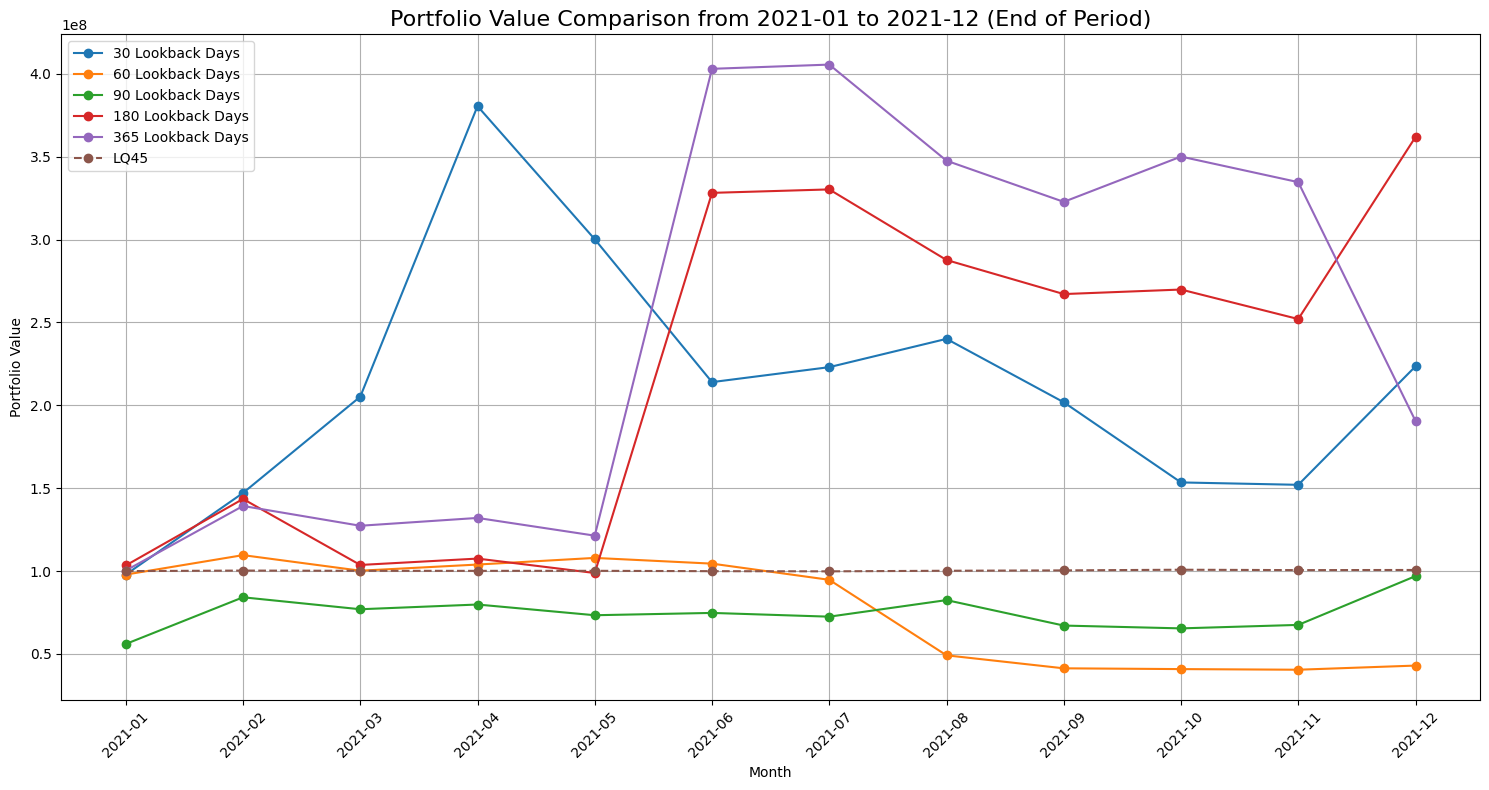

In [31]:
dataframes = [final_30, final_60, final_90, final_180, final_365, portfolio_history_lq45]
labels = ["30 Lookback Days", "60 Lookback Days", "90 Lookback Days", "180 Lookback Days", "365 Lookback Days", "LQ45"]

plt.figure(figsize=(15, 8))
for df, label in zip(dataframes, labels):
    if label == "LQ45":
        plt.plot(df['Period'], df['Final_Cap'], marker='o', linestyle='--', label=label)
    else:
        plt.plot(df['Period'], df['Final_Cap'], marker='o', label=label)

plt.xlabel('Month')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Comparison from 2021-01 to 2021-12 (End of Period)', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

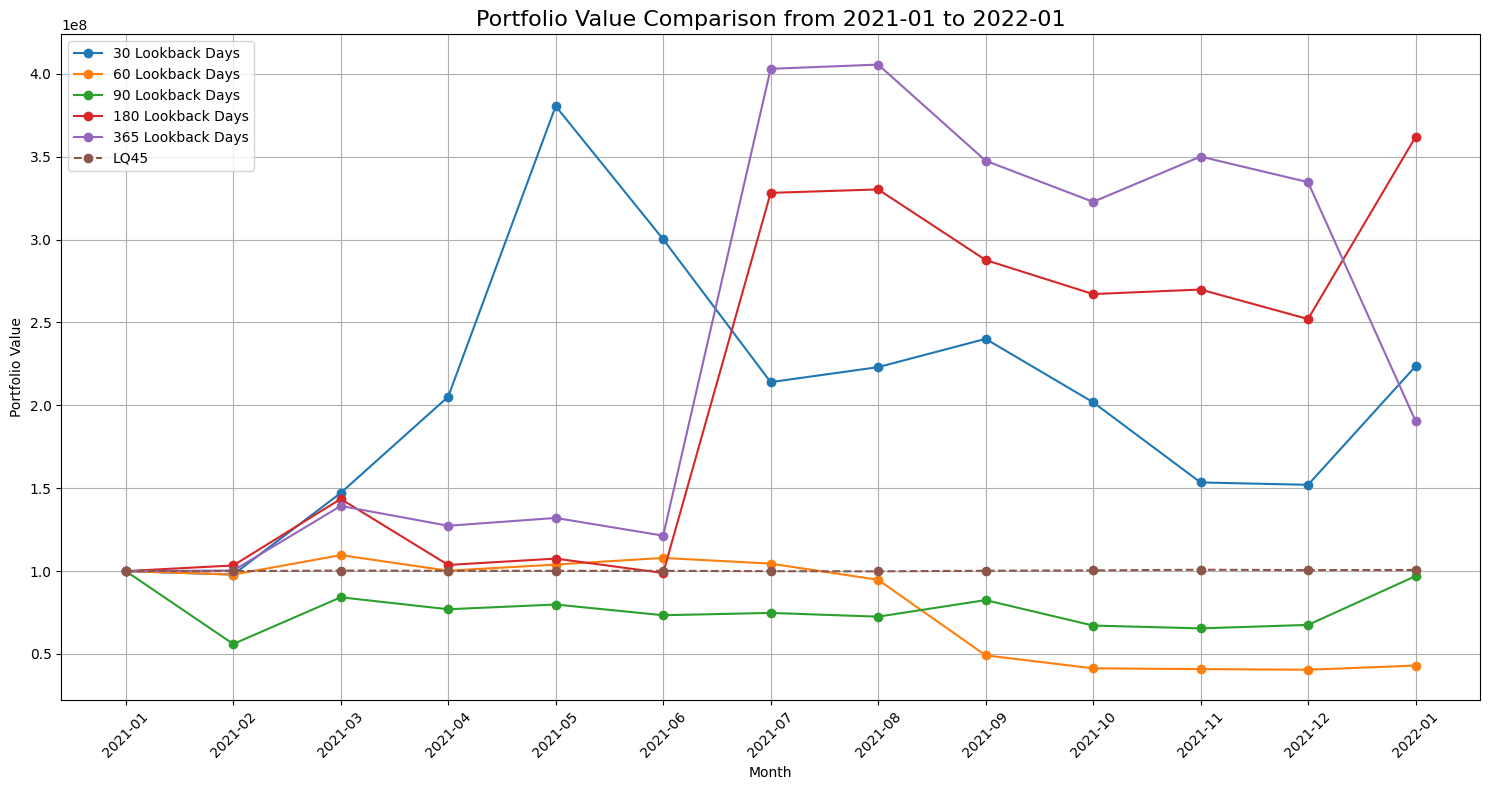

In [32]:
plt.figure(figsize=(15, 8))

initial_cap = 1e8
starting_month = '2021-01'  
x_ticks = pd.date_range(start='2021-01', end='2022-01', freq='MS').strftime('%Y-%m')  # Generate manual x-ticks

for df, label in zip(dataframes, labels):
    # initial point 1e8
    initial_df = pd.DataFrame({
        'Period': [starting_month],
        'Final_Cap': [initial_cap]
    })
    
    df_with_initial = pd.concat([initial_df, df], ignore_index=True)
    
    if label == "LQ45":
        plt.plot(x_ticks, df_with_initial['Final_Cap'], marker='o', linestyle='--', label=label)
    else:
        plt.plot(x_ticks, df_with_initial['Final_Cap'], marker='o', label=label)

plt.xticks(x_ticks, rotation=45)

plt.xlabel('Month')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Comparison from 2021-01 to 2022-01', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
def calculate_metrics(df, label):
    annualized_return = (df['Final_Cap'].iloc[-1] / df['Init_Cap'].iloc[0] - 1) * 100

    return {
        'Label': label,
        'Annualized Return': f"{annualized_return:.2f}%"
    }

metrics_list = []
metrics_list.append(calculate_metrics(final_30, "30 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(final_60, "60 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(final_90, "90 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(final_180, "180 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(final_365, "365 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(portfolio_history_lq45, "LQ45"))

print("Highlights")
# print("Return")
for metrics in metrics_list:
    print(f"{metrics['Label']}:")
    print(f"  Annualized Return: {metrics['Annualized Return']}")
    print()


Highlights
30 Lookback Days Portfolio:
  Annualized Return: 123.50%

60 Lookback Days Portfolio:
  Annualized Return: -57.00%

90 Lookback Days Portfolio:
  Annualized Return: -3.03%

180 Lookback Days Portfolio:
  Annualized Return: 261.86%

365 Lookback Days Portfolio:
  Annualized Return: 90.55%

LQ45:
  Annualized Return: 0.68%



In [34]:
# explode list values
expanded_final_30 = final_30.explode(['stock', 'weight', 'Weighted_Invest',
                                      'Return/Loss_Percentage', 'Cap_Gain/Loss'])
expanded_final_60 = final_60.explode(['stock', 'weight', 'Weighted_Invest',
                                      'Return/Loss_Percentage', 'Cap_Gain/Loss'])
expanded_final_90 = final_90.explode(['stock', 'weight', 'Weighted_Invest',
                                      'Return/Loss_Percentage', 'Cap_Gain/Loss'])
expanded_final_180 = final_180.explode(['stock', 'weight', 'Weighted_Invest',
                                      'Return/Loss_Percentage', 'Cap_Gain/Loss'])
expanded_final_365 = final_365.explode(['stock', 'weight', 'Weighted_Invest',
                                      'Return/Loss_Percentage', 'Cap_Gain/Loss'])

expanded_final_30.reset_index(drop=True, inplace=True)
expanded_final_60.reset_index(drop=True, inplace=True)
expanded_final_90.reset_index(drop=True, inplace=True)
expanded_final_180.reset_index(drop=True, inplace=True)
expanded_final_365.reset_index(drop=True, inplace=True)

In [35]:
expanded_df = pd.concat([expanded_final_30, expanded_final_60, 
                          expanded_final_90, expanded_final_180, 
                          expanded_final_365], ignore_index=True)
expanded_df

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2021-01,30,11.076236,AGRO.JK,0.1,1.000000e+08,10000000.0,-21.08,-2107843.14,9.789216e+07
1,2021-01,30,11.076236,PTDU.JK,0.9,1.000000e+08,90000000.0,0.0,0.0,9.789216e+07
2,2021-02,30,11.160090,BBHI.JK,0.1,9.789216e+07,9789215.69,119.86,11733173.42,1.471269e+08
3,2021-02,30,11.160090,DCII.JK,0.9,9.789216e+07,88102941.17,42.57,37501543.47,1.471269e+08
4,2021-03,30,12.843715,BANK.JK,1.0,1.471269e+08,147126873.75,39.47,58076397.53,2.052033e+08
...,...,...,...,...,...,...,...,...,...,...
120,2021-10,365,5.437222,BBHI.JK,0.1,3.227254e+08,32272537.36,59.15,19089591.06,3.500413e+08
121,2021-10,365,5.437222,DCII.JK,0.9,3.227254e+08,290452836.24,2.83,8226333.05,3.500413e+08
122,2021-11,365,5.449660,BBHI.JK,0.1,3.500413e+08,35004129.77,16.95,5932903.35,3.346157e+08
123,2021-11,365,5.449660,DCII.JK,0.9,3.500413e+08,315037167.94,-6.78,-21358452.06,3.346157e+08


In [36]:
expanded_df.rename(columns={
    'Period': 'period',
    'Lookback_Days': 'datapoints',
    'stock': 'assets',
    'weight': 'allocations',
    'Weighted_Invest': 'allocations_idr',
    'Return/Loss_Percentage': 'pnl_percentage',
    'Cap_Gain/Loss': 'pnl_idr',
    'Final_Cap': 'end_of_period_value'
}, inplace=True)

In [37]:
expanded_df = expanded_df[['period', 'datapoints', 'assets', 'allocations',
                          'allocations_idr', 'pnl_percentage', 'pnl_idr',
                          'end_of_period_value']]
expanded_df.dropna(inplace=True)
expanded_df

,period,datapoints,assets,allocations,allocations_idr,pnl_percentage,pnl_idr,end_of_period_value
0,2021-01,30,AGRO.JK,0.1,10000000.0,-21.08,-2107843.14,9.789216e+07
1,2021-01,30,PTDU.JK,0.9,90000000.0,0.0,0.0,9.789216e+07
2,2021-02,30,BBHI.JK,0.1,9789215.69,119.86,11733173.42,1.471269e+08
3,2021-02,30,DCII.JK,0.9,88102941.17,42.57,37501543.47,1.471269e+08
4,2021-03,30,BANK.JK,1.0,147126873.75,39.47,58076397.53,2.052033e+08
...,...,...,...,...,...,...,...,...
120,2021-10,365,BBHI.JK,0.1,32272537.36,59.15,19089591.06,3.500413e+08
121,2021-10,365,DCII.JK,0.9,290452836.24,2.83,8226333.05,3.500413e+08
122,2021-11,365,BBHI.JK,0.1,35004129.77,16.95,5932903.35,3.346157e+08
123,2021-11,365,DCII.JK,0.9,315037167.94,-6.78,-21358452.06,3.346157e+08


In [38]:
# end of period value dari masing-masing ticker
expanded_df['end_of_period_value'] = expanded_df['allocations_idr'] + expanded_df['pnl_idr']
expanded_df

,period,datapoints,assets,allocations,allocations_idr,pnl_percentage,pnl_idr,end_of_period_value
0,2021-01,30,AGRO.JK,0.1,10000000.0,-21.08,-2107843.14,7892156.86
1,2021-01,30,PTDU.JK,0.9,90000000.0,0.0,0.0,90000000.0
2,2021-02,30,BBHI.JK,0.1,9789215.69,119.86,11733173.42,21522389.11
3,2021-02,30,DCII.JK,0.9,88102941.17,42.57,37501543.47,125604484.64
4,2021-03,30,BANK.JK,1.0,147126873.75,39.47,58076397.53,205203271.28
...,...,...,...,...,...,...,...,...
120,2021-10,365,BBHI.JK,0.1,32272537.36,59.15,19089591.06,51362128.42
121,2021-10,365,DCII.JK,0.9,290452836.24,2.83,8226333.05,298679169.29
122,2021-11,365,BBHI.JK,0.1,35004129.77,16.95,5932903.35,40937033.12
123,2021-11,365,DCII.JK,0.9,315037167.94,-6.78,-21358452.06,293678715.88


In [39]:
expanded_df[expanded_df['allocations'] == 0]

,period,datapoints,assets,allocations,allocations_idr,pnl_percentage,pnl_idr,end_of_period_value
7,2021-05,30,BINA.JK,0.0,0.0,0,-0.0,0.0
38,2021-06,60,BMAS.JK,0.0,0.0,0,-0.0,0.0
53,2021-01,90,AGRO.JK,0.0,0.0,0,-0.0,0.0
63,2021-05,90,DCII.JK,0.0,0.0,0,0.0,0.0
69,2021-08,90,DMMX.JK,0.0,0.0,0,0.0,0.0
71,2021-08,90,TRUE.JK,0.0,0.0,0,-0.0,0.0
74,2021-10,90,BBHI.JK,0.0,0.0,0,0.0,0.0


In [40]:
# drop allocations == 0
expanded_df = expanded_df[expanded_df['allocations'] != 0]

### Final LQ45

In [41]:
final_lq45 = pd.DataFrame({
    'period': portfolio_history_lq45['Period'].values,
    'datapoints': 0, 
    'assets': 'LQ45', 
    'allocations': 1, 
    'allocations_idr': np.nan, 
    'pnl_percentage': np.nan, 
    'pnl_idr': np.nan, 
    'end_of_period_value': portfolio_history_lq45['Final_Cap'].values 
})

In [42]:
final_lq45.loc[0, 'allocations_idr'] = 1e8
final_lq45.loc[1:, 'allocations_idr'] = final_lq45['end_of_period_value'].shift(1).iloc[1:]
final_lq45['allocations_idr'] = round(final_lq45['allocations_idr'], 2)
final_lq45['end_of_period_value'] = round(final_lq45['end_of_period_value'], 2)

final_lq45

,period,datapoints,assets,allocations,allocations_idr,pnl_percentage,pnl_idr,end_of_period_value
0,2021-01,0,LQ45,1,1.000000e+08,NaN,NaN,9.999126e+07
1,2021-02,0,LQ45,1,9.999126e+07,NaN,NaN,1.003153e+08
2,2021-03,0,LQ45,1,1.003153e+08,NaN,NaN,1.001606e+08
3,2021-04,0,LQ45,1,1.001606e+08,NaN,NaN,1.001471e+08
4,2021-05,0,LQ45,1,1.001471e+08,NaN,NaN,1.001696e+08
5,2021-06,0,LQ45,1,1.001696e+08,NaN,NaN,9.995291e+07
6,2021-07,0,LQ45,1,9.995291e+07,NaN,NaN,9.984840e+07
7,2021-08,0,LQ45,1,9.984840e+07,NaN,NaN,1.002045e+08
8,2021-09,0,LQ45,1,1.002045e+08,NaN,NaN,1.004242e+08
9,2021-10,0,LQ45,1,1.004242e+08,NaN,NaN,1.008232e+08


In [43]:
final_lq45['pnl_idr'] = round(final_lq45['end_of_period_value'] - final_lq45['allocations_idr'], 2)
final_lq45['pnl_percentage'] = round((final_lq45['pnl_idr'] / final_lq45['allocations_idr']) * 100, 2)
final_lq45

,period,datapoints,assets,allocations,allocations_idr,pnl_percentage,pnl_idr,end_of_period_value
0,2021-01,0,LQ45,1,1.000000e+08,-0.01,-8737.83,9.999126e+07
1,2021-02,0,LQ45,1,9.999126e+07,0.32,324012.81,1.003153e+08
2,2021-03,0,LQ45,1,1.003153e+08,-0.15,-154723.93,1.001606e+08
3,2021-04,0,LQ45,1,1.001606e+08,-0.01,-13474.70,1.001471e+08
4,2021-05,0,LQ45,1,1.001471e+08,0.02,22563.88,1.001696e+08
5,2021-06,0,LQ45,1,1.001696e+08,-0.22,-216735.04,9.995291e+07
6,2021-07,0,LQ45,1,9.995291e+07,-0.10,-104501.23,9.984840e+07
7,2021-08,0,LQ45,1,9.984840e+07,0.36,356093.69,1.002045e+08
8,2021-09,0,LQ45,1,1.002045e+08,0.22,219712.91,1.004242e+08
9,2021-10,0,LQ45,1,1.004242e+08,0.40,398940.18,1.008232e+08


In [44]:
expanded_df = pd.concat([expanded_df, final_lq45], ignore_index=True)
expanded_df

,period,datapoints,assets,allocations,allocations_idr,pnl_percentage,pnl_idr,end_of_period_value
0,2021-01,30,AGRO.JK,0.1,10000000.0,-21.08,-2107843.14,7892156.86
1,2021-01,30,PTDU.JK,0.9,90000000.0,0.0,0.0,90000000.0
2,2021-02,30,BBHI.JK,0.1,9789215.69,119.86,11733173.42,21522389.11
3,2021-02,30,DCII.JK,0.9,88102941.17,42.57,37501543.47,125604484.64
4,2021-03,30,BANK.JK,1.0,147126873.75,39.47,58076397.53,205203271.28
...,...,...,...,...,...,...,...,...
125,2021-08,0,LQ45,1,99848403.96,0.36,356093.69,100204497.65
126,2021-09,0,LQ45,1,100204497.65,0.22,219712.91,100424210.56
127,2021-10,0,LQ45,1,100424210.56,0.4,398940.18,100823150.74
128,2021-11,0,LQ45,1,100823150.74,-0.24,-237137.14,100586013.6


# Metadata
- **period**: the month of the current date
- **datapoints**: number of datapoints fed into the algorithm
- **assets**: the name of the stock
- **allocations**: percentage of investment allocated towards the stock
- **allocations_idr**: amount of money invested towards the stock
- **pnl**: percentage of profit/loss of the invested stock in a month
- **pnl_idr**: amount of profit/loss of the invested stock in a month
- **end_of_period_value**: amount of value after one month investment

In [45]:
expanded_df.to_csv("summarized_portfolio_2021.csv", index=False)